# Getting Started

In [ ]:
# Naming conventions (to be modified)
# 1. Use short variable names but not too short. So that any variable name can
# be uniquely found using Ctrl+F
# 2. Use underscore to concatenate words/numbers in one variable name

# Next steps
# 1. Write user inputs to *.inp file in Section [User inputs] (like e4d.inp)
# 2. Load *.inp and set global variables in Section [Global variables]
# 3. Modify lines to read in mesh in a safer way
# 4. When implementing 3rd kind B.C., the number of edges can be reduced by
# in_stern = (in_stern)&((np.abs(g_s)>0)|(np.abs(q_s)>0))

#4/5/2022 (fighting!)
# 5. Just added variables radius_b, e_0, f_0, s_0. Use them in the code
# 6. Consider is it possible to make c/alpha/beta/gamma 4 by 4 (Maybe yes!)

## Main subroutines

### Basic functions

In [30]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
plt.style.use('seaborn-poster')

import copy,os,subprocess,time
import numpy as np
import numpy.matlib
from scipy import constants
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

def system_check():
    print('Run system check')
    print('Default numpy.int is %d bits'%np.iinfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    print('')
    return

def basis():
    
    
    return Je

# def rotate_line(nodes):
    
#     return R

# def set_mesh(mesh_prefix):
#     mesh={}
#     return mesh

if __name__=='__main__':
    system_check()
    print('Done')

Run system check
Default numpy.int is 64 bits
Default numpy.float is 64 bits

Done


## Sphere mesh (thin DL)

### User inputs

In [ ]:
#placeholder
#need to consider which variables are user inputs

# E4D files
# 1. file .inp
# 2. file .sig
# 3. file .cfg
# 4. file .inv (skip for sip)
# 5. file .out
# 6. file .srv

# Possible SIP files
# 1. file .inp (specifies run_mode: 1 for mesh generation; 2 for static solution; 3 for coupled solution)
# 2. file .hdf5 (stores mesh and material properties for domain equation and boundary equation)
# 3. file .cfg (will generate .poly for triangle; will be compatible with sphere/slab/membrane models)
# 4. file .out (specifies output options)
# 5. file .srv (specifies survey/external field options)

### Global variables

In [20]:
#make sure the user inputs meet the following requirements
#1) all numbers are float
#2) c_ion, z_ion, and mu_a have the same length
#3) empty c_ion/z_ion/mu_a means no diffuse layer
#4) empty mu_s means no stern layer

%reset -f

#USER INPUT block
#*******************************************************************************
#-------------------------------------------------------------------------------
#===============================================================================
#mesh name prefix
mesh_prefix = 'sphere_coupled'

#triangle executable path
triangle = '/home/zhuy359/projects/E4D/third_party/triangle/triangle'

#physical properties
rel_perm_a = 80.0 #relative permittivity of electrolyte [SI]
rel_perm_i = 4.5 #relative permittivity of solid [SI]
temperature = 293.0 #ambient temperature [K]

c_ion = [1.0,1.0] #ion concentration at infinity [mol/m^3]
z_ion = [1.0,1.0] #ion valence or charge number [SI]

mu_a = [5e-8,5e-8] #ion mobility in electrolyte [m^2/(Vs)]
mu_s = 5e-9 #ion mobility in solid [m^2/(Vs)]

#mesh properties
radius_a = 5e-6 #radius of the sphere particle
radius_b = 10*radius_a #radius of the bounding box

#external field source
e_0 = [10.0,0.0] #Ex/Ey at infinity
f_0 = [0.0,30e-9,0.0] #coord_x/coord_y/charge density 
s_0 = 0.0 #voltage on equipotential surface

#hard coded mesh indexing constants
elem_flag_solid = 1
elem_flag_water = 2
elem_flag_air = 3

edge_flag_sw_interface = 1
edge_flag_aw_interface = 2
edge_flag_equipotental_surface = 3
edge_flag_axis_symmetry = 4

edge_flag_infty_top = 11
edge_flag_infty_bottom = 12
edge_flag_infty_left = 13
edge_flag_infty_right = 14

#DO NOT modify below
#*******************************************************************************
#-------------------------------------------------------------------------------
#===============================================================================

def debye_length():
    n_ion = len(c_ion)
    Db_len=[0.0]*n_ion
    for i in range(n_ion):
        Db_len[i] = np.sqrt(perm_a*K_B*temperature/2/q_ion[i]/q_ion[i]/Conc_ion[i])
        
    return Db_len

#set physicsical constants
q_e = constants.value(u'elementary charge') #1.602e-19 [C]
perm_0 = constants.value(u'vacuum electric permittivity') #8.85e-12 [F/m]
N_A = constants.value(u'Avogadro constant') #6.022e23 [1/mol]
K_B = constants.value(u'Boltzmann constant') #1.381e-23 [J/K]
K_F = constants.value(u'Faraday constant') #96485.0 [C/mol]

#derive variables from user inputs
perm_a = rel_perm_a*perm_0
perm_i = rel_perm_i*perm_0
Diff_a = [val*K_B*temperature/q_e for val in mu_a]
Diff_s = mu_s*K_B*temperature/q_e

q_ion = [val*q_e for val in z_ion]
Conc_ion = [val*N_A for val in c_ion]
Db_len = debye_length()

print('Done')

NameError: name 'constants' is not defined

### Radial discretization

DEBYE LENGTH IS: 9.63e+00 nm
Done


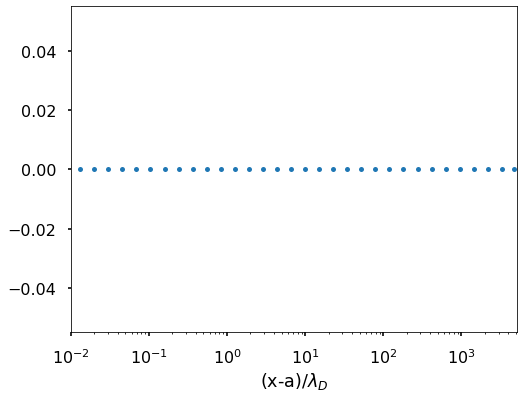

In [2]:
def discretize_rho():
    print('DEBYE LENGTH IS: %.2e nm'%(min(Db_len)*1e9))

    rho=np.logspace(np.log10(0.02),1,16)*min(Db_len)+radius_a
    #print(rho[0],rho[-1])
    dr=np.diff(np.log10((rho-radius_a)/min(Db_len)))[0]
    rho=np.power(10,np.arange(np.log10(0.02)-dr,1+dr*14,dr))*min(Db_len)+radius_a
    #print(rho[1],rho[16])
    rho=np.r_[0,radius_a,rho,radius_b]
    #print('See radial discretization below')
    #print(rho)
    #print(np.pi*radius_a/400,rho[2]-radius_a)
    
    fig,ax=plt.subplots(figsize=(8,6))
    mask=rho>radius_a
    ax.plot((rho[mask]-radius_a)/min(Db_len),np.zeros_like(rho[mask]),'o',markersize=5)
    ax.set_xscale('log')
    ax.set_xlim(0.01,radius_b/min(Db_len))
    ax.set_xlabel('(x-a)/$\lambda_D$')
    
    return rho.astype(float)

if __name__=='__main__':
    rho=discretize_rho()
    print('Done')
    plt.show()

### Mesh generation

Opening sphere_coupled.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  12
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  1
Adding Steiner points to enforce quality.
Quality milliseconds:  86

Writing sphere_coupled.1.node.
Writing sphere_coupled.1.ele.
Writing sphere_coupled.1.poly.
Writing sphere_coupled.1.edge.
Writing sphere_coupled.1.neigh.

Output milliseconds:  319
Total running milliseconds:  478

Statistics:

  Input vertices: 7780
  Input segments: 469
  Input holes: 0

  Mesh vertices: 38012
  Mesh triangles: 75838
  Mesh edges: 113849
  Mesh exterior boundary edges: 184
  Mesh interior boundary edges: 5377
  Mesh subsegments (constrained edges): 5561

Done


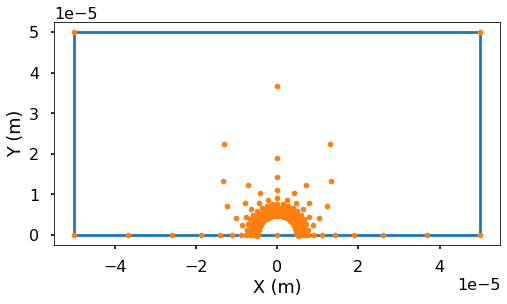

In [3]:
def generate_mesh():
    #X is the longitudinal axis
    #Y is the axis of symmetry
    cpts = np.zeros((0,3)) #coord_x/coord_y/flag of control points
    segs = np.zeros((0,3)) #ind_a/ind_b/flag of line segmenets
    holes = np.zeros((0,2)) #coord_x/coord_y
    zones = np.zeros((0,3)) #coord_x/coord_y/area
    
    x = np.r_[0.0,0.0]
    y = np.r_[0.5*radius_a,2.0*radius_a]
    area = np.r_[1e12,(radius_b/20)**2]
    zones = np.r_[zones,np.c_[x,y,area]]
    
    #***************************************************************************
    #---------------------------------------------------------------------------
    #===========================================================================
    #define the two corner points on the topmost boundary
    x = np.r_[radius_b,-radius_b]
    y = np.r_[radius_b,radius_b]
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the points on the axis of symmetry (Y = 0)
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*1]] #node flag of 1
    
    #define the inner sphere points centered at (0,0) with radius a
    dA = max(np.pi*radius_a/400,rho[2]-radius_a)/radius_a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(1,ns+1)*dA #half the circle
    x = radius_a*np.cos(phi)+0.0
    y = radius_a*np.sin(phi)+0.0
    cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0
    
    #define the inner refined points
    for i in range(3,len(rho)-1):
        dA = max(np.pi*radius_a/400,rho[i]-rho[i-1])/radius_a
        nA = np.ceil(np.pi/dA)
        ns = nA+1-2
        
        dA = np.pi/nA
        phi = np.arange(1,ns+1)*dA
        x = rho[i]*np.cos(phi)+0.0
        y = rho[i]*np.sin(phi)+0.0
        cpts = np.r_[cpts,np.c_[x,y,np.ones(len(x))*0]] #node flag of 0

    #***************************************************************************
    #---------------------------------------------------------------------------
    #===========================================================================
    #define the segments on the topmost boundary (Y = 10*a)
    x = np.r_[radius_b,-radius_b]
    y = np.r_[radius_b,radius_b]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,edge_flag_infty_top]] #predefined edge flag

    #define the segments on the axis of symmetry (Y = 0)
    x = np.r_[np.flipud(-rho),rho[1:]]
    y = np.zeros(len(rho)*2-1)
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,edge_flag_axis_symmetry]] #predefined edge flag
        
    #define the segments on the leftmost boundary (X = -10*a)
    x = np.r_[-radius_b,-radius_b]
    y = np.r_[0,radius_b]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,edge_flag_infty_left]] #edge flag of 6

    #define the segmesnts on the rightmost boundary (X = 10*a)
    x = np.r_[radius_b,radius_b]
    y = np.r_[0,radius_b]
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,edge_flag_infty_right]] #predefined edge flag
    
    #define the segments along the inner sphere centered at (0,0) with radius a
    dA = max(np.pi*radius_a/400,rho[2]-radius_a)/radius_a
    nA = np.ceil(np.pi/dA)
    ns = nA+1-2
    
    dA = np.pi/nA
    phi = np.arange(0,ns+2)*dA #half the circle
    x = radius_a*np.cos(phi)+0.0
    y = radius_a*np.sin(phi)+0.0
    for i in range(len(x)-1):
        ind_a = np.argmin((cpts[:,0]-x[i])**2+(cpts[:,1]-y[i])**2)
        ind_b = np.argmin((cpts[:,0]-x[i+1])**2+(cpts[:,1]-y[i+1])**2)
        segs = np.r_[segs,np.c_[ind_a,ind_b,edge_flag_sw_interface]] #predefined edge flag
    
    
    #***************************************************************************
    #---------------------------------------------------------------------------
    #===========================================================================
    #build the poly file
    f1 = open(mesh_prefix+'.poly','w')
    f1.write(str(len(cpts))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers\n')
    
    #write the vertices
    cnt = 1
    for i in range(len(cpts)):
        f1.write("{0:6.0F} {1:20.5F} {2:20.5F} {3:6.0F}\n".format(cnt,cpts[i,0]*1e6,cpts[i,1]*1e6,cpts[i,2]))
        cnt = cnt+1
    f1.write('\n')
    
    #write the segments
    cnt = 1
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(len(segs)):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} {3:6.0F}\n".format(cnt,segs[i,0]+1,segs[i,1]+1,segs[i,2]))
        cnt = cnt+1
    f1.write('\n')
    
    #write holes
    #f1.write('\n\n0\n\n')
    f1.write('%d\n'%(len(holes)))
    for i in range(len(holes)):
        x = holes[i,0]*1e6
        y = holes[i,1]*1e6
        f1.write('{0:6.0F} {1:12.6F} {2:12.6F} 1\n'.format(i+1,x,y))
    f1.write('\n')
    
    #write area constraints for zones
    #f1.write('2\n')
    #f1.write('1 {0:12.6F} {1:12.6F} 1 {2:12.6F}\n'.format(0.0,0.5e6*a,1e12))
    #f1.write('2 {0:12.6F} {1:12.6F} 2 {2:12.6F}\n'.format(0.0,2e6*a,(10e6*a/20)**2))
    f1.write('%d\n'%(len(zones)))
    for i in range(len(zones)):
        x = zones[i,0]*1e6
        y = zones[i,1]*1e6
        area = zones[i,2]*1e12
        f1.write('{0:6.0F} {1:12.6F} {2:12.6F} {3:6.0F} {4:12.6F}\n'.format(i+1,x,y,i+1,area))

    f1.write('\n')
    f1.write('# triangle -pnq30Aae '+mesh_prefix+'.poly \n')
    f1.close()
    
    fig,ax=plt.subplots(figsize=(8,6))
    x=cpts[segs[:,:-1].astype(int),0]
    y=cpts[segs[:,:-1].astype(int),1]
    ax.plot(x.T,y.T,'-',color='tab:blue')
    ax.plot(cpts[:,0],cpts[:,1],'.',color='tab:orange')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_aspect('equal')
    return cpts.astype(float),segs.astype(int)

if __name__=='__main__':
    cpts,segs=generate_mesh()
    process=subprocess.Popen([triangle+' -pnq30Aae '+mesh_prefix+'.poly'],shell=True)
    process.wait()
    print('Done')
    plt.show()


### Mesh properties

Reading sphere_coupled.1.node
Reading sphere_coupled.1.ele
Reading sphere_coupled.1.edge
THE NUMBER OF NODES IS: 38012
THE NUMBER OF ELEMENTS IS: 75838
THE NUMBER OF EDGES IS: 113849
node_flags [ 0  1  4 11 13 14]
elem_flags [1 2]
edge_flags [ 0  1  4 11 13 14]

Done


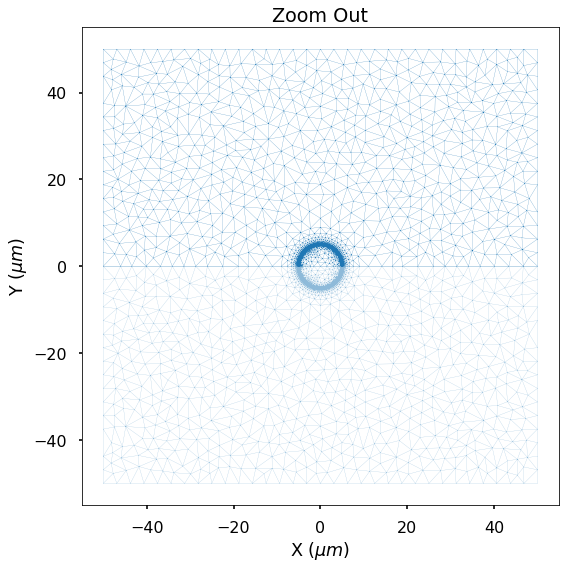

In [19]:
def set_mesh():
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2),dtype=float)
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype=int)

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype=int)
    elem_flags=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype=int)

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype=int)
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype=int)

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1
    
    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6
    
    n_node=len(nodes)
    n_elem=len(elements)
    n_edge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%n_node)
    print('THE NUMBER OF ELEMENTS IS: %d'%n_elem)
    print('THE NUMBER OF EDGES IS: %d'%n_edge)
    print('node_flags',np.unique(node_flags))
    print('elem_flags',np.unique(elem_flags))
    print('edge_flags',np.unique(edge_flags))
    print('')
    
    #**************************************************************************
    #--------------------------------------------------------------------------
    #==========================================================================
    #display mesh
    disp_factor=1e6
    x=nodes[:,0]*disp_factor
    y=nodes[:,1]*disp_factor
    
    fig,ax=plt.subplots(figsize=(8,8))    
    ax.triplot(x,y,elements[:,:],linewidth=0.2,color='tab:blue')
    ax.triplot(x,-y,elements[:,:],linewidth=0.2,color='tab:blue',alpha=0.5)
    ax.set_xlabel('X $(\mu m)$')
    ax.set_ylabel('Y $(\mu m)$')
    ax.set_aspect('equal')
    ax.set_title('Zoom Out')
    
    mesh = {}
    mesh['nodes'] = nodes.astype(float)
    mesh['elements'] = elements.astype(int)
    mesh['edges'] = edges.astype(int)
    mesh['node_flags'] = node_flags.astype(int)
    mesh['elem_flags'] = elem_flags.astype(int)
    mesh['edge_flags'] = edge_flags.astype(int)
    return mesh

if __name__=='__main__':
    mesh=set_mesh()
    print('Done')
    plt.tight_layout()
    plt.show()

### Material properties

In [18]:
def set_materials():
    #define bookkeeping variables
    n_ion=len(c_ion)
    n_dim=2
    
    n_node=len(mesh['nodes'])
    n_elem=len(mesh['elements'])
    n_edge=len(mesh['edges'])
    
    #shortcut to variables in mesh
    nodes = mesh['nodes']
    elements = mesh['elements']
    edges = mesh['edges']
    
    node_flags = mesh['node_flags']
    elem_flags = mesh['elem_flags']
    edge_flags = mesh['edge_flags']
    
    #variables of static solutions
    conc_stat = np.ones((n_elem,n_ion),dtype=complex) #to be updated
    pot_stat = np.ones((n_elem,n_dim+1),dtype=complex) #to be updated
    
    #initialize variables in domain
    domain = {}
    domain['c_x']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=complex)
    domain['c_y']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=complex)
    domain['c_z']=None #placeholder
    domain['alpha_x']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=complex)
    domain['alpha_y']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=complex)
    domain['alpha_z']=None #placeholder
    domain['beta_x']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=complex)
    domain['beta_y']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=complex)
    domain['beta_z']=None #placeholder
    domain['gamma_x']=np.zeros((n_elem,n_ion+2),dtype=complex)
    domain['gamma_y']=np.zeros((n_elem,n_ion+2),dtype=complex)
    domain['gamma_z']=None #placeholder
    domain['a']=np.zeros((n_elem,n_ion+2,n_ion+2),dtype=complex)
    domain['f']=np.zeros((n_elem,n_ion+2),dtype=complex)
    domain['g_s']=np.zeros((n_edge,n_ion+2,n_ion+2),dtype=complex)
    domain['q_s']=np.zeros((n_edge,n_ion+2),dtype=complex)
    domain['s_n']=np.zeros((n_node,n_ion+2),dtype=complex)
    domain['a_n']=np.zeros((n_node,n_ion+2,n_ion+2),dtype=complex)
    domain['f_n']=np.zeros((n_node,n_ion+2),dtype=complex)
    
    domain['c_x_stern']=np.zeros((n_edge,n_ion+2),dtype=complex)
    domain['c_y_stern']=None
    domain['alpha_x_stern']=np.zeros((n_edge,n_ion+2,n_ion+2),dtype=complex)
    domain['alpha_y_stern']=None
    domain['beta_x_stern']=np.zeros((n_edge,n_ion+2,n_ion+2),dtype=complex)
    domain['beta_y_stern']=None
    domain['gamma_x_stern']=np.zeros((n_edge,n_ion+2,n_ion+2),dtype=complex)
    domain['gamma_y_stern']=None
    domain['a_stern']=np.zeros((n_edge,n_ion+2,n_ion+2),dtype=complex)
    domain['f_stern']=np.zeros((n_edge,n_ion+2),dtype=complex)
    
    domain['in_air']=np.zeros(n_elem,dtype=bool)
    domain['in_water']=np.zeros(n_elem,dtype=bool)
    domain['in_solid']=np.zeros(n_elem,dtype=bool)
    domain['in_stern']=np.zeros(n_edge,dtype=bool)
    domain['with_1st_kind_bc']=np.zeros((n_edge,n_ion+2),dtype=bool)
    domain['with_3rd_kind_bc']=np.zeros((n_edge,n_ion+2),dtype=bool)
    domain['on_source_nodes']=np.zeros((n_node,n_ion+2),dtype=bool)
    
    #set domain properties in the solid
    in_solid = elem_flags==elem_flag_solid    
    domain['c_x'][in_solid,:n_ion,:n_ion] = 0.0 #cx for all ions
    domain['c_y'][in_solid,:n_ion,:n_ion] = 0.0 #cy for all ions
    
    domain['a'][in_solid,:n_ion,:n_ion] = 1.0 #a for all ions
    
    domain['c_x'][in_solid,n_ion,n_ion] = perm_i #cx for potential
    domain['c_y'][in_solid,n_ion,n_ion] = perm_i #cy for potential
    
    freq = 1.0 #normalized frequency
    domain['a'][in_solid,n_ion,n_ion] = 1j*freq #a for potential
    
    #set domain properties in the water
    in_water = elem_flags==elem_flag_water
    for i in range(n_ion):
        domain['c_x'][in_water,i,i] = Diff_a[i] #cx for the i^th ion
        domain['c_y'][in_water,i,i] = Diff_a[i] #cy for the i^th ion
        
        domain['c_x'][in_water,i,n_ion] = mu_a[i]*z_ion[i]*conc_stat[in_water,i] #cx for the i^th ion
        domain['c_y'][in_water,i,n_ion] = mu_a[i]*z_ion[i]*conc_stat[in_water,i] #cy for the i^th ion
    
        domain['alpha_x'][in_water,i,i] = mu_a[i]*z_ion[i]*pot_stat[in_water,1] #alpha_x for the i^th ion
        domain['alpha_y'][in_water,i,i] = mu_a[i]*z_ion[i]*pot_stat[in_water,2] #alpha_y for the i^th ion
        
        domain['a'][in_water,n_ion,i] = -z_ion[i]*K_F ##a for the i^th ion
        
    domain['c_x'][in_water,n_ion,n_ion] = perm_a #cx for potential
    domain['c_y'][in_water,n_ion,n_ion] = perm_a #cy for potential
    
    #set domain properties in the air
    in_air = elem_flags==elem_flag_air
    domain['c_x'][in_air,:n_ion,:n_ion] = 0.0 #cx for all ions
    domain['c_y'][in_air,:n_ion,:n_ion] = 0.0 #cy for all ions
    
    domain['a'][in_air,:n_ion,:n_ion] = 1.0 #a for all ions
    
    domain['c_x'][in_air,n_ion,n_ion] = perm_0 #cx for potential
    domain['c_y'][in_air,n_ion,n_ion] = perm_0 #cy for potential
    
    domain['a'][in_air,n_ion,n_ion] = 0.0 #a for potential
    
    #set domain properties in Stern layer (3rd type B.C.)
    with_3rd_kind_bc = edge_flags==edge_flag_sw_interface
    sigma_stern = 1.0 #normalized surface charge density in Stern layer
    domain['g_s'][with_3rd_kind_bc,n_ion] = 1.0*sigma_stern #gs for potential
    
    #set domain properties on Dirichlet boundary (1st type B.C.)
    with_1st_kind_bc = edge_flags==edge_flag_infty_top
    with_1st_kind_bc = with_1st_kind_bc|edge_flags==edge_flag_infty_bottom
    with_1st_kind_bc = with_1st_kind_bc|edge_flags==edge_flag_infty_left
    with_1st_kind_bc = with_1st_kind_bc|edge_flags==edge_flag_infty_right
    nind_bc = np.unique(edges[with_1st_kind_bc,:].flatten(order='C'))
    domain['s_n'][nind_bc,:n_ion] = 0.0 #s_n for all ions
    e0 = 1.0 #normalized electric field strength
    domain['s_n'][nind_bc,n_ion] = -nodes[nind_bc,0]*e0 #s_n for potential
    
    #set mesh indexing variables in domain
    domain['in_solid'][:] = in_solid
    domain['in_water'][:] = in_water
    domain['in_air'][:] = in_air
    for i in range(n_ion+2): #low efficiency
        domain['with_1st_kind_bc'][:,i] = with_1st_kind_bc
        domain['with_3rd_kind_bc'][:,i] = with_3rd_kind_bc
    
#     #**************************************************************************
#     #--------------------------------------------------------------------------
#     #==========================================================================
#     #initialize variables in bound
#     bound = {}
#     bound['c_x']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=complex)
#     bound['c_y']=None
#     bound['c_z']=None
#     bound['alpha_x']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=complex)
#     bound['alpha_y']=None
#     bound['alpha_z']=None
#     bound['beta_x']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=complex)
#     bound['beta_y']=None
#     bound['beta_z']=None
#     bound['gamma_x']=np.zeros((n_edge,n_ion+1),dtype=complex)
#     bound['gamma_y']=None
#     bound['gamma_z']=None
#     bound['a']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=complex)
#     bound['f']=np.zeros((n_edge,n_ion+1),dtype=complex)
#     bound['g_s']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=complex)
#     bound['q_s']=np.zeros((n_edge,n_ion+1),dtype=complex)
#     bound['s_n']=np.zeros((n_node,n_ion+1),dtype=complex)
#     bound['a_n']=np.zeros((n_node,n_ion+1,n_ion+1),dtype=complex)
#     bound['f_n']=np.zeros((n_node,n_ion+1),dtype=complex)

#     bound['in_stern']=np.zeros(n_edge,dtype=bool)
#     bound['with_1st_kind_bc']=np.zeros((n_node,n_ion+1),dtype=bool)
#     bound['with_3rd_kind_bc']=np.zeros((n_node,n_ion+1),dtype=bool)
#     bound['on_source_nodes']=np.zeros((n_node,n_ion+1),dtype=bool)
    
#     #set Stern layer properties
#     #continue from here 4/5/2022
    
#     #set Dirichlet boundary condition
#     #continue from here 4/5/2022

    return domain

if __name__=='__main__':
    domain=set_materials()
    print('Done')

Done


In [15]:
# del bound
print('='*80)
%whos list
print('='*80)
%whos dict

Variable   Type    Data/Info
----------------------------
Conc_ion   list    n=2
Db_len     list    n=2
Diff_a     list    n=2
c_ion      list    n=2
e_0        list    n=2
f_0        list    n=3
mu_a       list    n=2
q_ion      list    n=2
z_ion      list    n=2
Variable   Type    Data/Info
----------------------------
domain     dict    n=36
mesh       dict    n=6


# Main subroutines

## Reset notebook

In [40]:
%reset -f
%whos

import copy,os,subprocess,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

#set physical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro's constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]
kF=96485.0 #Faraday's constant [As/mol] equal to kA*echarge


Interactive namespace is empty.


## Initialize global variables

In [41]:
%reset -f
import matplotlib.pyplot as plt
import matplotlib.tri as tri
plt.style.use('seaborn-poster')
#plt.style.use('ggplot')

import copy,os,subprocess,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

#set physical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro's constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]
kF=96485.0 #Faraday's constant [As/mol] equal to kA*echarge

#predefine user input variables
mesh_prefix='placeholder' #mesh prefix

perm_a=0.0 #relative permittivity of electrolyte [SI]
perm_i=0.0 #relative permittivity of solid [SI]
temperature=0.0 #ambient temperature [K]

n_ion=2 #number of ion types (0 means no diffuse layer)
c_ion=[0.0]*n_ion #ion concentration at infinity [mol/m^3]
z_ion=[0.0]*n_ion #ion valence or charge number [SI]
q_ion=[0.0]*n_ion #electric charge (q) in [Coulombs]
debye_len=[0.0]*n_ion #Debye length [m]
mu_a=[0.0]*n_ion #ion mobility in electrolyte [m^2/(Vs)]
mu_i=[0.0]*n_ion #ion mobility in solid [m^2/(Vs)]
Diff_a=[0.0]*n_ion #diffusion coefficient in electrolyte [m^2/s]
Diff_i=[0.0]*n_ion #diffusion coefficient in solid [m^2/s]

#predefine mesh variables
n_dim=2 #2D simulation
n_node=0 #number of total nodes
n_elem=0 #number of total triangular elements
n_edge=0 #number of total line segments

nodes=np.zeros((n_node,n_dim),dtype=float) #[X,Y]
elements=np.zeros((n_elem,n_dim+1),dtype=int) #[ind_a,ind_b,ind_c]
edges=np.zeros((n_edge,n_dim),dtype=int) #[ind_a,ind_b]

node_flags=np.zeros(n_node,dtype=bool) #node flags
elem_flags=np.zeros(n_elem,dtype=bool) #zones
edge_flags=np.zeros(n_edge,dtype=bool) #edge flags

#hard coded mesh indexing constants 
elem_flag_air=1
elem_flag_water=2
elem_flag_solid=3
edge_flag_stern=1

edge_flag_1st_kind_bc=[1,1,1]
edge_flag_3rd_kind_bc=[1,1,1]

node_flag_1st_kind_bc=[1,1,1]
node_flag_3rd_kind_bc=[1,1,1]

#predefine material and mesh properties for domain equation
domain={}
domain['c_x']=np.zeros((n_elem,n_ion+1,n_ion+1),dtype=float)
domain['c_y']=np.zeros((n_elem,n_ion+1,n_ion+1),dtype=float)
domain['c_z']=None
domain['alpha_x']=np.zeros((n_elem,n_ion+1,n_ion+1),dtype=float)
domain['alpha_y']=np.zeros((n_elem,n_ion+1,n_ion+1),dtype=float)
domain['alpha_z']=None
domain['beta_x']=np.zeros((n_elem,n_ion+1,n_ion+1),dtype=float)
domain['beta_y']=np.zeros((n_elem,n_ion+1,n_ion+1),dtype=float)
domain['beta_z']=None
domain['gamma_x']=np.zeros((n_elem,n_ion+1),dtype=float)
domain['gamma_y']=np.zeros((n_elem,n_ion+1),dtype=float)
domain['gamma_z']=None
domain['a']=np.zeros((n_elem,n_ion+1,n_ion+1),dtype=float)
domain['f']=np.zeros((n_elem,n_ion+1),dtype=float)
domain['g_s']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=float)
domain['q_s']=np.zeros((n_edge,n_ion+1),dtype=float)
domain['s_n']=np.zeros((n_node,n_ion+1),dtype=float)
domain['a_n']=np.zeros((n_node,n_ion+1,n_ion+1),dtype=float)
domain['f_n']=np.zeros((n_node,n_ion+1),dtype=float)

domain['in_air']=np.zeros(n_elem,dtype=bool)
domain['in_water']=np.zeros(n_elem,dtype=bool)
domain['in_solid']=np.zeros(n_elem,dtype=bool)
domain['with_1st_kind_bc']=np.zeros((n_edge,n_ion+1),dtype=bool)
domain['with_3rd_kind_bc']=np.zeros((n_edge,n_ion+1),dtype=bool)
domain['on_source_nodes']=np.zeros((n_node,n_ion+1),dtype=bool)

#predefine mesh and material properties for boundary equation
bound={}
bound['c_x']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=float)
bound['c_y']=None
bound['c_z']=None
bound['alpha_x']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=float)
bound['alpha_y']=None
bound['alpha_z']=None
bound['beta_x']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=float)
bound['beta_y']=None
bound['beta_z']=None
bound['gamma_x']=np.zeros((n_edge,n_ion+1),dtype=float)
bound['gamma_y']=None
bound['gamma_z']=None
bound['a']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=float)
bound['f']=np.zeros((n_edge,n_ion+1),dtype=float)
bound['g_s']=np.zeros((n_edge,n_ion+1,n_ion+1),dtype=float)
bound['q_s']=np.zeros((n_edge,n_ion+1),dtype=float)
bound['s_n']=np.zeros((n_node,n_ion+1),dtype=float)
bound['a_n']=np.zeros((n_node,n_ion+1,n_ion+1),dtype=float)
bound['f_n']=np.zeros((n_node,n_ion+1),dtype=float)

bound['in_stern']=np.zeros(n_edge,dtype=bool)
bound['with_1st_kind_bc']=np.zeros((n_node,n_ion+1),dtype=bool)
bound['with_3rd_kind_bc']=np.zeros((n_node,n_ion+1),dtype=bool)
bound['on_source_nodes']=np.zeros((n_node,n_ion+1),dtype=bool)

#https://www.wrighters.io/how-to-view-all-your-variables-in-a-jupyter-notebook/
# %whos ndarray
%whos dict
print('')
print('-'*28)
import pprint
pprint.pprint(domain)


Variable   Type    Data/Info
----------------------------
bound      dict    n=23
domain     dict    n=25

----------------------------
{'a': array([], shape=(0, 3, 3), dtype=float64),
 'a_n': array([], shape=(0, 3, 3), dtype=float64),
 'alpha_x': array([], shape=(0, 3, 3), dtype=float64),
 'alpha_y': array([], shape=(0, 3, 3), dtype=float64),
 'alpha_z': None,
 'beta_x': array([], shape=(0, 3, 3), dtype=float64),
 'beta_y': array([], shape=(0, 3, 3), dtype=float64),
 'beta_z': None,
 'c_x': array([], shape=(0, 3, 3), dtype=float64),
 'c_y': array([], shape=(0, 3, 3), dtype=float64),
 'c_z': None,
 'f': array([], shape=(0, 3), dtype=float64),
 'f_n': array([], shape=(0, 3), dtype=float64),
 'g_s': array([], shape=(0, 3, 3), dtype=float64),
 'gamma_x': array([], shape=(0, 3), dtype=float64),
 'gamma_y': array([], shape=(0, 3), dtype=float64),
 'gamma_z': None,
 'in_air': array([], dtype=bool),
 'in_solid': array([], dtype=bool),
 'in_water': array([], dtype=bool),
 'on_source_nodes': ar

# Test Case 1

## Pesudocode